# PyTorch Metric Learning
### Example for the TrainWithClassifier trainer
See the documentation [here](https://kevinmusgrave.github.io/pytorch-metric-learning/)

## Install the necessary packages

In [ ]:
!pip install -q pytorch-metric-learning[with-hooks]
!pip install umap-learn

## Import the packages

In [ ]:
%matplotlib inline
import logging

import matplotlib.pyplot as plt
import numpy as np
import record_keeper
import torch
import torch.nn as nn
import torchvision
import umap
from cycler import cycler
from PIL import Image
from torchvision import datasets, transforms

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.84


## Simple model def

In [ ]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

## Initialize models, optimizers and image transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 64]).to(device))

# Set the classifier. The classifier will take the embeddings and output a 50 dimensional vector.
# (Our training set will consist of the first 50 classes of the CIFAR100 dataset.)
# We'll specify the classification loss further down in the code.
classifier = torch.nn.DataParallel(MLP([64, 50])).to(device)

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(
    embedder.parameters(), lr=0.0001, weight_decay=0.0001
)
classifier_optimizer = torch.optim.Adam(
    classifier.parameters(), lr=0.0001, weight_decay=0.0001
)

# Set the image transforms
train_transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Create the dataset and class-disjoint train/val splits

In [ ]:
# Download the original datasets
original_train = datasets.CIFAR100(
    root="CIFAR100_Dataset", train=True, transform=None, download=True
)
original_val = datasets.CIFAR100(
    root="CIFAR100_Dataset", train=False, transform=None, download=True
)

# This will be used to create train and val sets that are class-disjoint
class ClassDisjointCIFAR100(torch.utils.data.Dataset):
    def __init__(self, original_train, original_val, train, transform):
        rule = (lambda x: x < 50) if train else (lambda x: x >= 50)
        train_filtered_idx = [
            i for i, x in enumerate(original_train.targets) if rule(x)
        ]
        val_filtered_idx = [i for i, x in enumerate(original_val.targets) if rule(x)]
        self.data = np.concatenate(
            [
                original_train.data[train_filtered_idx],
                original_val.data[val_filtered_idx],
            ],
            axis=0,
        )
        self.targets = np.concatenate(
            [
                np.array(original_train.targets)[train_filtered_idx],
                np.array(original_val.targets)[val_filtered_idx],
            ],
            axis=0,
        )
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target


# Class disjoint training and validation set
train_dataset = ClassDisjointCIFAR100(
    original_train, original_val, True, train_transform
)
val_dataset = ClassDisjointCIFAR100(original_train, original_val, False, val_transform)
assert set(train_dataset.targets).isdisjoint(set(val_dataset.targets))

Files already downloaded and verified
Files already downloaded and verified


##Create the loss, miner, sampler, and package them into dictionaries


In [ ]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# Set the classification loss:
classification_loss = torch.nn.CrossEntropyLoss()

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    train_dataset.targets, m=4, length_before_new_iter=len(train_dataset)
)

# Set other training parameters
batch_size = 32
num_epochs = 4

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder, "classifier": classifier}
optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer,
    "classifier_optimizer": classifier_optimizer,
}
loss_funcs = {"metric_loss": loss, "classifier_loss": classification_loss}
mining_funcs = {"tuple_miner": miner}

# We can specify loss weights if we want to. This is optional
loss_weights = {"metric_loss": 1, "classifier_loss": 0.5}

In [ ]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs/ example_saved_models/ example_tensorboard/

## Create the training and testing hooks

In [ ]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = "example_saved_models"


def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()


# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=32,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, dataset_dict, model_folder, test_interval=1, patience=1
)

## Create the trainer

In [ ]:
trainer = trainers.TrainWithClassifier(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    mining_funcs,
    train_dataset,
    sampler=sampler,
    dataloader_num_workers=32,
    loss_weights=loss_weights,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

## Start Tensorboard
(Turn off adblock and other shields)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir example_tensorboard

## Train the model

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
total_loss=1.59941: 100%|██████████| 937/937 [01:04<00:00, 14.53it/s]
INFO:root:Evaluating epoch 1
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:18<00:00, 50.31it/s] 
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


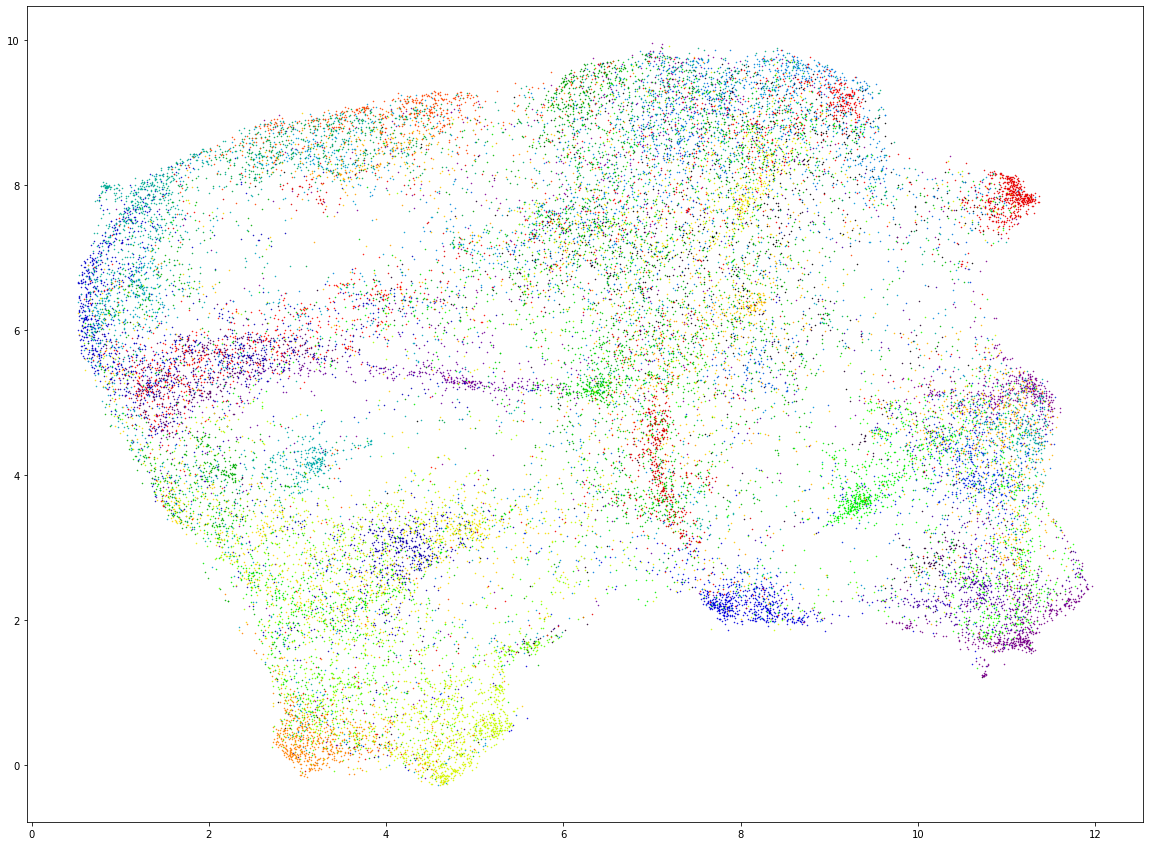

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 2
total_loss=1.17419: 100%|██████████| 937/937 [01:07<00:00, 13.78it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:19<00:00, 48.26it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


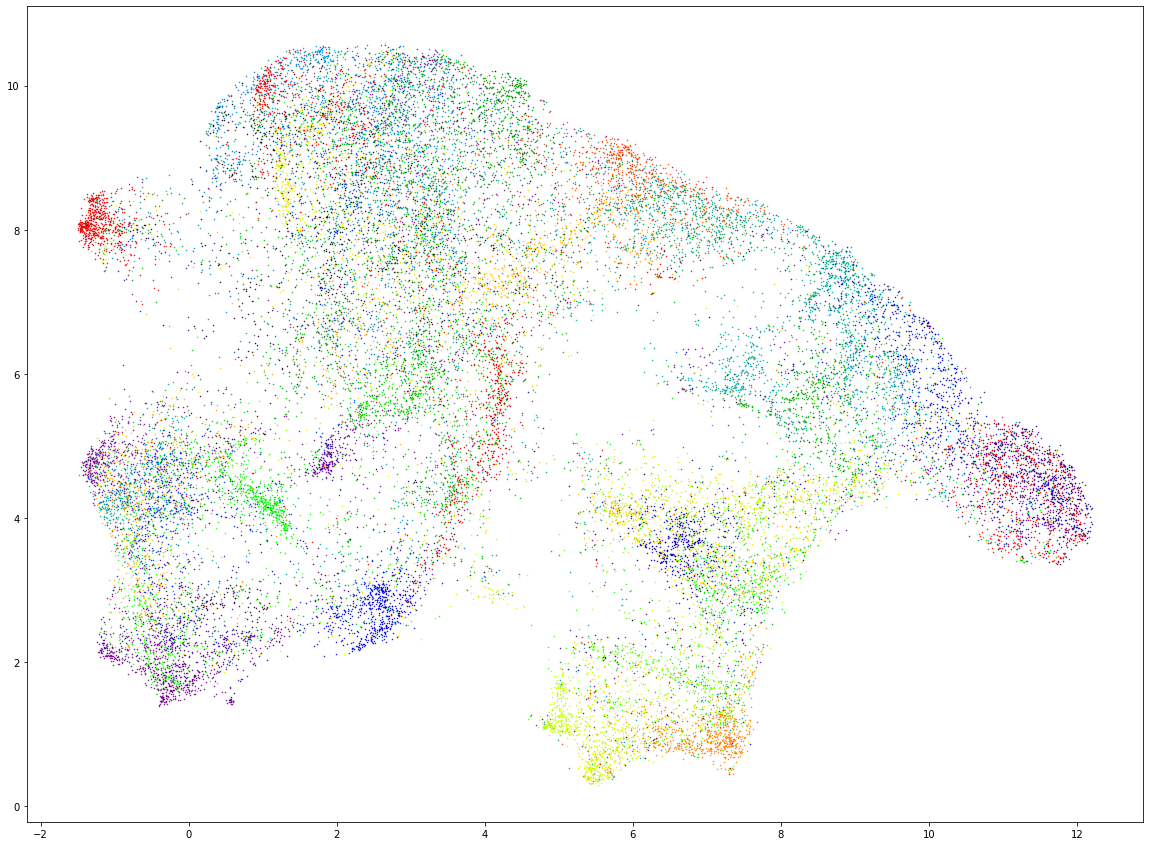

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 3
total_loss=1.05555: 100%|██████████| 937/937 [01:07<00:00, 13.93it/s]
INFO:root:Evaluating epoch 3
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:19<00:00, 49.27it/s] 
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


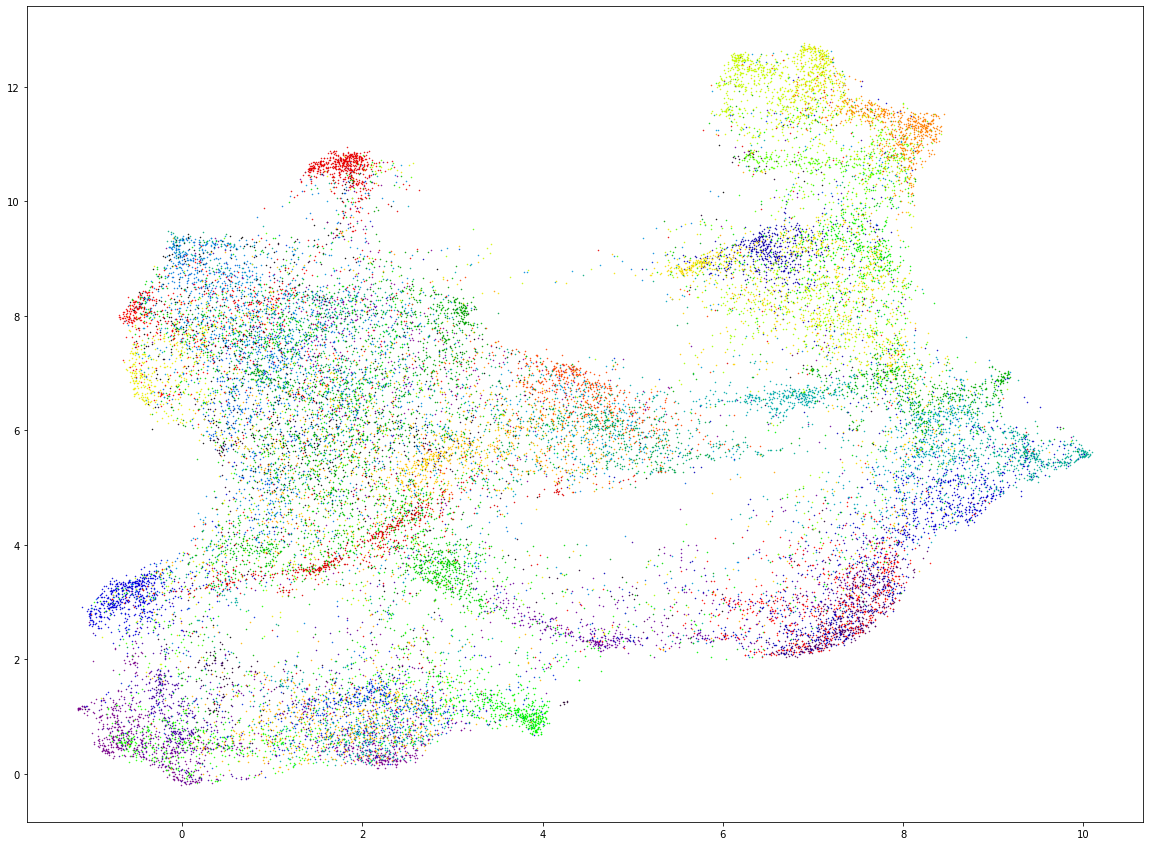

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 4
total_loss=1.41591: 100%|██████████| 937/937 [01:07<00:00, 13.84it/s]
INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:20<00:00, 44.78it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


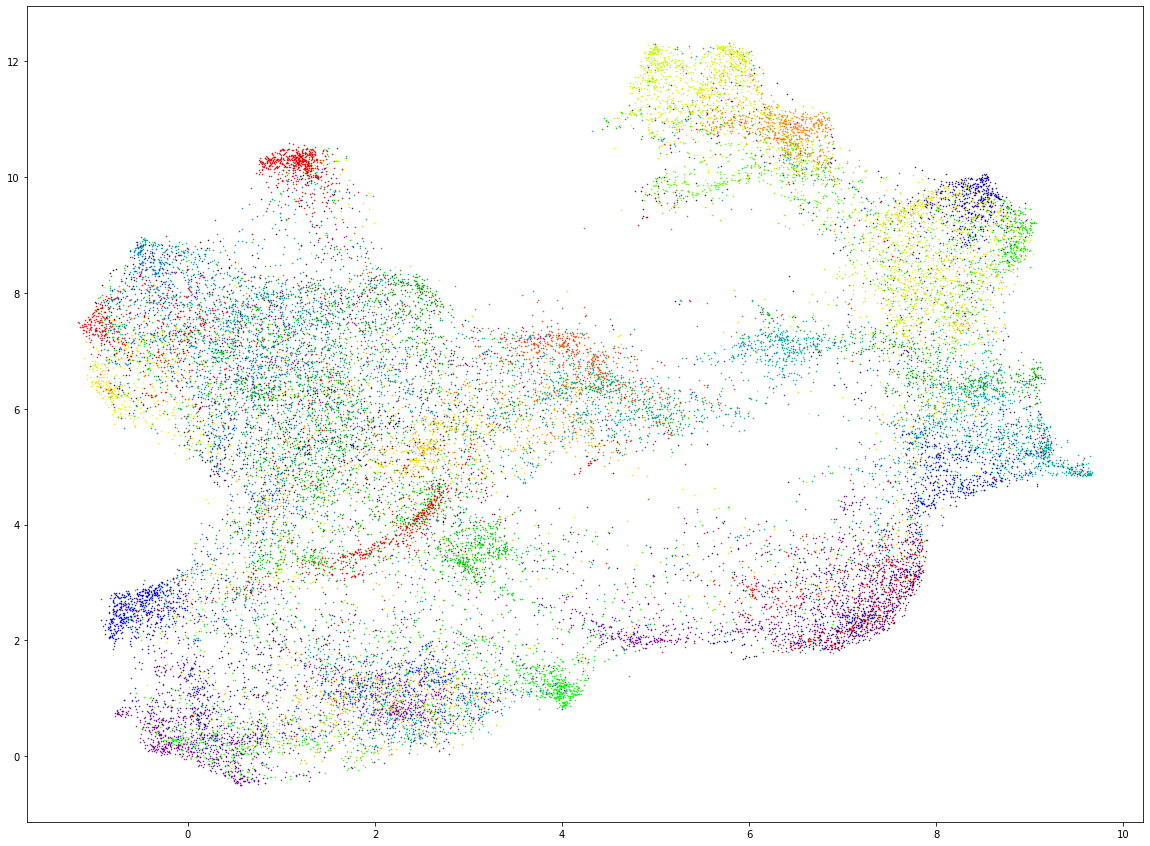

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!


In [ ]:
trainer.train(num_epochs=num_epochs)